# Shimming Simulation
This is a shimming simulation to shim with a given B0 field with cubic magnetic magnets.  
First the field shimming matrix is generated, saved and then the optimization problem is solved.

## Import Unshimmed B0 Field
First we import and display the field, which should be shimmed.

In [47]:
from shimmingFunctions import initSimulation
name = 'results/test'  # define name of the simulation

initSimulation(name)

New folder results/test created.


Saving parameters to file...  resolution dimensions FOV FOV diameter  B0 field homogeneity: 4076 ppm


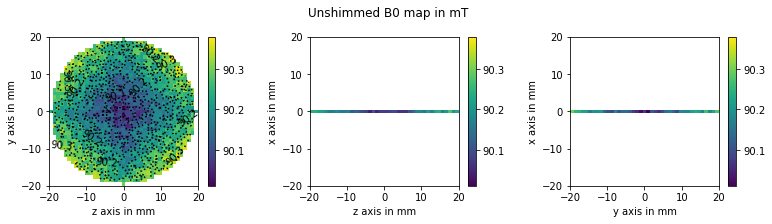

mean field 0.09022033914890931


In [48]:
import numpy as np
import matplotlib.pyplot as plt

from shimmingFunctions import genSphericalMask, plotSimple, centerCut, ptpPPM
from shimmingFunctions import saveParameters, genSliceMask, genMask, isHarmonic, importComsol

# import the b0 map
#field, res = importComsol('B0fieldMaps/6ringDesign_IdealField.csv')
#field = field[5:-5,5:-5,5:-5] #.swapaxes(0,1)
#field = 1e-3*np.load('B0fieldMaps/2021_03_22_DesktopMagnet_Shimming_d90mm_center_volume.npy')
#field = field[1:-1,1:-1,1:-1]

#random field
field = 0.09 + 0.01e-3*(
    10*np.random.rand(41,41,41) + np.abs(np.mgrid[0:41, 0:41, 0:41][2]-20) + np.abs(np.mgrid[0:41, 0:41, 0:41][1]-20)
)

# save field as a npy array
np.save(name+'/fieldBeforeShim', field)

# resolution of the simulation
dimensions = (0.040,0.040, 0.040)

# diameter of mask (spherical mask) [mm]
diameter = 40
# resolution of the B0 map [mm]
resolution = float(1)

# generate mask
#mask = genSphericalMask(field, diameter, resolution) # [bool] 
#isHarmonic(field, genSphericalMask(field, diameter, resolution), mask)
#mask = genMask(field, resolution, diameter=diameter, shellThickness=8, debug=True) # [bool] 
mask = genSliceMask(field, diameter, resolution, 'y') # [bool] 
# other masks are genSphericalMask, genMask, genSliceMask, genEllipseSliceMask

# apply mask to the data
field = np.multiply(field, mask) # [T]

# define FOV / simulation region (used for plotting)
FOV = (-0.02e3, 0.02e3, -0.02e3, 0.02e3) # [mm], [mm], [mm], [mm]

# save mask
np.save(name+'/mask', mask)

# save parameters: resolution, dimensions, FOV
parameters = {'resolution' : resolution, 'dimensions' : dimensions, 'FOV' : FOV, 'FOV diameter' : diameter}
saveParameters(parameters, name)

# display field
print("B0 field homogeneity: " + str(int(ptpPPM(field))) + " ppm")

fig, ax = plt.subplots(1,3,figsize=(11,3))
vmin = 1e3*np.nanmin(field); vmax = 1e3*np.nanmax(field)

plotSimple(1e3*centerCut(field, axis=0), FOV, fig, ax[0] , vmin=vmin, vmax=vmax)
ax[0].set_xlabel('z axis in mm'); ax[0].set_ylabel('y axis in mm')
plotSimple(1e3*centerCut(field, axis=1), FOV, fig, ax[1], vmin=vmin, vmax=vmax)
ax[1].set_xlabel('z axis in mm'); ax[1].set_ylabel('x axis in mm')
plotSimple(1e3*centerCut(field, axis=2), FOV, fig, ax[2], vmin=vmin, vmax=vmax)
ax[2].set_xlabel('y axis in mm'); ax[2].set_ylabel('x axis in mm')

plt.suptitle("Unshimmed B0 map in mT")
plt.tight_layout()
plt.savefig(name+"/unshimmedField.png")
plt.show()
print("mean field", np.nanmean(field))

## Generate Shim Matrix

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from shimmingFunctions import loadParameter, saveParameters, plotSimple, centerCut
from shimmingFunctions import createShimfields, calcDipolMomentAnalytical, createShimfieldsDoubleRings
from shimmingFunctions import createShimfieldsShimRingV2

size         = 9e-3     # [m] magnet edge length
remanence    = 1.296    # [T]
numMagnets   = (32, 44) # no of magnets in an inner and outer single ring
numShimRings = 2        # total number of shim rings 
radii        = (0.074, 0.097) # radius of inner and outer shim ring
zRange       = (-85.5e-3, 85.5e-3) # x-coordinate of the center of each shim ring
resolution   = 1000     # inverse resolution of SI units
kValue       = 1        # 2 = halbach, 1= radial
numRotations = 2        # half the number of allowed rotations of each magnet (e.g. 2 -> 0°, 90°, 180° 270°)
numTotalMagnets = np.sum(numMagnets)*numShimRings
dipolMomentsAreInShimMatrix = True


parameters = {
    'numMagnets' : numMagnets[0], 
    'numMagnets2' : numMagnets[1], 
    "numShimRings" : numShimRings, 
    "radius" : radii[0], 
    "radius2" : radii[1], 
    "zRange" : zRange, 
    "kValue" : kValue, 
    "numRotations" : numRotations, 
    "dipolMomentsAreInShimMatrix" : dipolMomentsAreInShimMatrix,
    "numTotalMagnets" : numTotalMagnets,
}

saveParameters(parameters, name)
if dipolMomentsAreInShimMatrix:
    parameters = {'size' : size, 'remanence' : remanence}
    saveParameters(parameters, name)

dimensions = loadParameter('dimensions', name)
resolution = loadParameter('resolution', name)

shimMagnetsFields = createShimfieldsShimRingV2(
    numMagnets = numMagnets, 
    rings = numShimRings, 
    radii = radii, 
    zRange = zRange, 
    resolution = 1e3 / resolution, # resolution is defined different here! also in SI
    kValue = kValue, 
    simDimensions = dimensions, 
    numRotations = numRotations
)

# if pockets cannot be populized set fields to 0
#for i in (0,1,2,3,4,5): # eg. for magnets 0,1,2,3,4,5
#    shimMagnetsFields[...,i] *= 0

if dipolMomentsAreInShimMatrix:
    shimMagnetsFields *= calcDipolMomentAnalytical(remanence, size**3)

# save shim matrix
np.save(name+'/shimMatrix', shimMagnetsFields)  # i am hugeeee! ~mb!

Saving parameters to file...  numMagnets numMagnets2 numShimRings radius radius2 zRange kValue numRotations dipolMomentsAreInShimMatrix numTotalMagnets    ... added.
Saving parameters to file...  size remanence    ... added.
304 (32, 44) 2 1
All magnets are simulated, the shim field array has shape: (41, 41, 41, 3, 304) 			,	 0.064,	 0.073


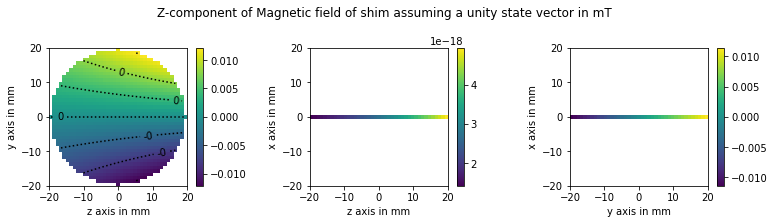

In [50]:
# plot the field of one magnet to see if everything is correct
from shimmingFunctions import dna2vector

if dipolMomentsAreInShimMatrix:
    # unitVector = dna2vector(np.ones(numMagnets*numShimRings*len(radii), dtype=int), [1.], numRotations, numMagnets*numShimRings*len(radii))
    unitVector = dna2vector(np.zeros(numTotalMagnets, dtype=int), [1.], numRotations, numTotalMagnets)

#unitVector *= 0
unitVector[119] = 1
    
ShimFieldUnitVector = np.matmul(shimMagnetsFields, unitVector)
ShimFieldUnitVector = np.multiply(ShimFieldUnitVector[...,2], mask)

FOV = loadParameter('FOV', name)

fig, ax = plt.subplots(1,3,figsize=(11,3))
vmin = 1e3*np.nanmin(ShimFieldUnitVector); vmax = 1e3*np.nanmax(ShimFieldUnitVector)

plotSimple(1e3*centerCut(ShimFieldUnitVector[...], axis=0), FOV, fig, ax[0])#, vmin=vmin, vmax=vmax)
ax[0].set_xlabel('z axis in mm'); ax[0].set_ylabel('y axis in mm')
plotSimple(1e3*centerCut(ShimFieldUnitVector[...], axis=1), FOV, fig, ax[1])#, vmin=vmin, vmax=vmax)
ax[1].set_xlabel('z axis in mm'); ax[1].set_ylabel('x axis in mm')
plotSimple(1e3*centerCut(ShimFieldUnitVector[...], axis=2), FOV, fig, ax[2])#, vmin=vmin, vmax=vmax)
ax[2].set_xlabel('y axis in mm'); ax[2].set_ylabel('x axis in mm')

plt.suptitle("Z-component of Magnetic field of shim assuming a unity state vector in mT")
plt.tight_layout()
#plt.savefig("shimmingField.png")
plt.show()
del ShimFieldUnitVector, unitVector

## Optimization
Now we want to use an optimization algorithm to find the best placements of the magnets using the shim matrix.

### Importing and vectorizing to increase to c-speed

In [51]:
import numpy as np
import multiprocessing
import ctypes

# load mask
mask = np.load(name+'/mask.npy')

# load unshimmed B0 map
field = np.load(name+'/fieldBeforeShim.npy')

#define target field as delta from the center field value
targetField =  field - field[int(np.shape(field)[0]/2),int(np.shape(field)[1]/2),int(np.shape(field)[2]/2)]

# vectorise the targetfield, include only the masked area in the vector
# this reduces the size of the matrix it has to calculate and speeds up simulations ~50% for a spherical mask
vectorisedTargetField = targetField[mask==1]

#Use shared memory for the arrays getting accessed in the cost function, roughly 10x faster than using standard arrays
#using float rather than double speeds up simulations by factor of 2
sharedHalbachField_base = multiprocessing.Array(ctypes.c_float, np.size(vectorisedTargetField))
sharedHalbachField = np.ctypeslib.as_array(sharedHalbachField_base.get_obj())
sharedHalbachField = sharedHalbachField.reshape(np.size(vectorisedTargetField,0))
sharedHalbachField[:] = vectorisedTargetField[:]
del vectorisedTargetField
del targetField

# load shim matrix
shimMatrix = np.load(name+'/shimMatrix.npy')

# only consider the relevant component of the magnetic field
shimMatrix = shimMatrix[:,:,:,2,:]

# masking and vectorizing shimming matrix
vectorisedShimFields = shimMatrix[mask == 1,:]

# casting to c
sharedShimMagnetsFields_base = multiprocessing.Array(ctypes.c_float, np.size(vectorisedShimFields))
sharedShimMagnetsFields = np.ctypeslib.as_array(sharedShimMagnetsFields_base.get_obj())
sharedShimMagnetsFields = sharedShimMagnetsFields.reshape(np.size(vectorisedShimFields,0),np.size(vectorisedShimFields,1))
sharedShimMagnetsFields[:,:] = vectorisedShimFields[:,:]
del sharedShimMagnetsFields_base, vectorisedShimFields

def cast1d2c(obj):
    """Cast a 1 dimensional array to a c array"""
    sharedBase = multiprocessing.Array(ctypes.c_float, np.size(obj))
    sharedObj  = np.ctypeslib.as_array(sharedBase.get_obj())
    sharedObj  = sharedObj.reshape(np.size(obj,0))#,np.size(sharedObj,1))
    return sharedObj

### Genetic Algorithm

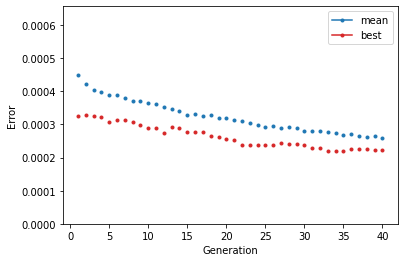

  Gen    40 took 0.677 seconds with fitness 0.00022318 (approx. ppm: 2472, best: 2432 ppm)	 40.00% conv. 0.00% (maximum approx. 00h 00m 24s to 00h 00m 08s left)
-- End of (successful) evolution --
Evolution took 00h 00m 17s and 8308 cost function calls.
Initial homogeneity: 4076.194190655315
Shimmed homogeneity: 2398.430140074518
Initial mean: 90.22033914890932 mT
Shimmed mean: 91.54233389297886 mT


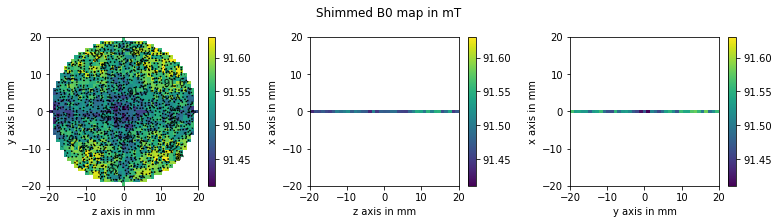

In [52]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from deap import creator, base, tools
from shimmingFunctions import ptpPPM, loadParameter, saveParameters, dna2vector
from shimmingFunctions import plotSimple, centerCut, saveResults


def fieldError(dipolMoments, numRotations, numMagnets, dna):
    """Casts dna to peak to peak deviation of magnetic field
    """
    shimVector = dna2vector(dna, dipolMoments, numRotations, numMagnets)
    #cast shim vector as a float, speeds up simulations > 50%
    shimVector = np.array(shimVector, dtype = np.float32)
    tempShimmedField = sharedHalbachField + np.matmul(sharedShimMagnetsFields, shimVector)
    return (np.abs(np.max(tempShimmedField)-np.min(tempShimmedField)),)

# Simple Configuration
popSim = 25000           # size of population
minGeneration = 300      # do not make me too small, fluctuations at the beginning can cause early stop
maxGeneration = 1000

# genetic propabilities
CXPB, MUTPB = 0.75, 0.2   # crossover and mutation
MUTINDPB = 0.05           # propability for mutation of a gene

parameters = {
    'popSim' : popSim,
    'minGeneration' : minGeneration,
    'maxGeneration' : maxGeneration,
    'CXPB' : CXPB,
    'MUTPB' : MUTPB,
    'MUTINDPB' : MUTINDPB
}
saveParameters(parameters, name)

numRotations = loadParameter('numRotations', name)
numMagnets = loadParameter('numMagnets', name)
numShimRings = loadParameter('numShimRings', name)
dipolMomentsAreInShimMatrix = loadParameter('dipolMomentsAreInShimMatrix', name)
numTotalMagnets = loadParameter('numTotalMagnets', name)
if dipolMomentsAreInShimMatrix == False:
    pass # to be implemented here

costFunctionCalls = np.copy(popSim)

if dipolMomentsAreInShimMatrix == True:
    numSizes = 1
numGenes = 2*numRotations*numSizes#    # maximal number of value of gene!

random.seed()

creator.create("FitnessMulti", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

#define values for individuals
toolbox.register("genes", random.randint, 0, numGenes)

#chromosome is defined here, each magnet position is one  gene, so the gene is numTotalMagnets long
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.genes, numTotalMagnets)

#define the population size, the number of different shimVectors in each generation
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

dipolMoments = []
if dipolMomentsAreInShimMatrix == True:
    dipolMoments += [1] # <- here in field data ##[calcDipolMomentAnalytical(remanence = remanence, volume = (size**3))]
else:
    for remanence, size in zip(remanences, sizes):
        dipolMoments += [calcDipolMomentAnalytical(remanence = remanence, volume = (size**3))]

toolbox.register("evaluate", fieldError, dipolMoments, numRotations, numTotalMagnets)

#define the evolutionary behaviour
toolbox.register("mate", tools.cxTwoPoint)

toolbox.register("mutate", tools.mutUniformInt, low=0, up=numGenes, indpb=MUTINDPB)

toolbox.register("select", tools.selTournament, tournsize=3)

pop = toolbox.population(n=popSim)

print("Start of evolution")
startTime = time.time()
fitnesses = list(map(toolbox.evaluate, pop))

for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit


print("  Evaluated %i individuals" % len(pop), end=" ")
print("  Evaluation took: " + str(time.time()-startTime) + " seconds")
fits = [ind.fitness.values[0] for ind in pop]

# Variable keeping track of the number of generations
g = 0
minTracker = []

startEvolution = time.time()

bestError = np.inf
realMin = []

# Begin the evolution
# while (g < minGeneration) or (np.argmin(minTracker) > 0.8*g):
while ((g < minGeneration) or (np.argmin(minTracker) > 0.8*g)) and (g < maxGeneration):
    startTime = time.time()
    # A new generation
    g = g + 1
    #print("-- Generation %i --" % g, end=" ")

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):

        # cross two individuals with probability CXPB
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            # fitness values of the children
            # must be recalculated later
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        # mutate an individual with probability MUTPB
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    
    #numInvalid = 0
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
        costFunctionCalls += 1
    
    # The population is entirely replaced by the offspring
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    minTracker += [min(fits)]
    
    #print("  Min %s" % min(fits), end="")
    estimatedTime = (maxGeneration-g) * (time.time() - startEvolution) / (g+1)
    estimatedTime = time.strftime("%Hh %Mm %Ss", time.gmtime(estimatedTime))
    estimatedTime2 = (maxGeneration-g) * (time.time()-startTime)
    estimatedTime2 = time.strftime("%Hh %Mm %Ss", time.gmtime(estimatedTime2))
    
    if min(fits) < bestError:
        #print("\nNEW BEST!")
        bestError = min(fits)
        realMin = tools.selBest(pop, 1)[0]
        
    plt.plot(g, np.mean(fits), marker='.', color='tab:blue')
    plt.plot(g, minTracker[-1], marker='.', color='tab:red')
    plt.xlabel("Generation"); plt.ylabel("Error")
    plt.ylim(0, 2*np.nanmax(minTracker))
    plt.legend(['mean', 'best'])
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    if min(fits) != np.inf:
        print("  Gen {:5} took {:.5} seconds with fitness {:.5} (approx. ppm: {}, best: {} ppm)".format(g, str(time.time()-startTime), min(fits), int(1e6*min(fits)/np.nanmean(field)), int(1e6*(bestError/np.nanmean(field)))), end="")
        print("\t {:.2f}% conv. {:.2f}% (maximum approx. {} to {} left)".format(100*g/maxGeneration, (125*np.argmin(minTracker)/g)%100, estimatedTime, estimatedTime2), end="\r")
    else:
        print("Infinity", g*'.', end='\r')

plt.close()
print("\n-- End of (successful) evolution --")
totalTime = time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()- startEvolution))
print("Evolution took " + totalTime + " and {} cost function calls.".format(costFunctionCalls))


#bestVector = np.array(dna2vector(realMin, dipolMoments, numRotations, numMagnets*numShimRings))
bestVector = np.array(dna2vector(realMin, dipolMoments, numRotations, numTotalMagnets))

shim = np.matmul(shimMatrix, bestVector)

shimmedFieldUnmasked = field + shim

shim = np.multiply(shim, mask) # [T]
field = np.multiply(field, mask) # [T]

shimmedField = field + shim

print("Initial homogeneity: " + str(ptpPPM(field)))
print("Shimmed homogeneity: " + str(ptpPPM(shimmedField)))
print("Initial mean: " + str(1e3*np.nanmean(field)) + " mT")
print("Shimmed mean: " + str(1e3*np.nanmean(shimmedField)) + " mT")

results = {
    "Initial homogeneity: " : str(ptpPPM(field)),
    "Shimmed homogeneity: " : str(ptpPPM(shimmedField)),
    "Initial mean:" : str(1e3*np.nanmean(field)) ,
    "Shimmed mean: " : str(1e3*np.nanmean(shimmedField)),
    'costFunctionCalls' : costFunctionCalls,
    'totalTime' : totalTime,
    'bestVector' : bestVector,
    'realMin' : np.array(realMin),
    'Generations' : g,
}

saveResults(results, shimmedFieldUnmasked, name)

FOV = loadParameter('FOV', name)

fig, ax = plt.subplots(1,3,figsize=(11,3))
vmin = 1e3*np.nanmin(shimmedField); vmax = 1e3*np.nanmax(shimmedField)

plotSimple(1e3*centerCut(shimmedField, axis=0), FOV, fig, ax[0], vmin=vmin, vmax=vmax)
ax[0].set_xlabel('z axis in mm'); ax[0].set_ylabel('y axis in mm')
plotSimple(1e3*centerCut(shimmedField, axis=1), FOV, fig, ax[1], vmin=vmin, vmax=vmax)
ax[1].set_xlabel('z axis in mm'); ax[1].set_ylabel('x axis in mm')
plotSimple(1e3*centerCut(shimmedField, axis=2), FOV, fig, ax[2], vmin=vmin, vmax=vmax)
ax[2].set_xlabel('y axis in mm'); ax[2].set_ylabel('x axis in mm')

plt.suptitle("Shimmed B0 map in mT")
plt.tight_layout()
plt.savefig(name+"/shimmedField.png")
plt.show()

### Print results

In [53]:
import numpy as np
data = np.load(name+'/results0.npy', allow_pickle=True)

print(data)

{'Initial homogeneity: ': '4076.194190655315', 'Shimmed homogeneity: ': '2398.430140074518', 'Initial mean:': '90.22033914890932', 'Shimmed mean: ': '91.54233389297886', 'costFunctionCalls': array(8308), 'totalTime': '00h 00m 17s', 'bestVector': array([ 0, -1,  0,  0,  0,  0, -1, -1,  0,  0,  1,  0,  0, -1, -1, -1,  1,
        0,  0,  1, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  1,
       -1,  0,  0, -1,  0, -1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  1,
        0,  0,  0, -1,  1,  0,  0, -1,  0,  0,  0,  1,  1,  0,  0,  0, -1,
        1,  1,  0, -1, -1,  0,  0,  0,  0,  0,  0, -1,  0, -1, -1,  0,  0,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1, -1,  0,  0, -1,
        0,  0, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0, -1,  0,
        0, -1,  0, -1,  0,  1,  0,  1,  1,  0, -1,  0,  0, -1,  0,  1,  1,
        0,  0,  1,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0, -1, -1,  1,  1,
        0,  0, -1, -1, -1,  0,  0, -1,  0,  0,  1, -1,  0,  0,  0,  0, -1,
    